In [1]:
import numpy as np
import torch
from mdof_solutions import add_noise
result_ids = [
    '20240812__sr_exten_67dr_6dof_nonerr_50snr',   # 0
    '20240813__sr_exten_67dr_20dof_nonerr_50snr',  # 1
    '20240813__sr_exten_67dr_6dof_linmod_50snr',   # 2
    '20240820__sr_exten_67dr_6dof_valerr_50snr',   # 3
    '20240813__sr_exten_67dr_6dof_nonerr_20snr',   # 4
    '20240813__sr_exten_67dr_6dof_nonerr_10snr',   # 5
]
result_id = result_ids[3]
results = torch.load(f'results/{result_id}.pth')
ground_truth = results['ground_truth']
# data = results['data']
prediction = results['prediction']
alphas = results['alphas']
lin_solution = results['lin_solution']
model_dict = results['model']
prescr_params = results['prescribed_params']
true_params = results['true_params']

n_dof = lin_solution['x'].shape[0]
lin_solution['v'] = lin_solution['xdot']

In [ ]:
def print_prescribed_params(prescr_params):
    for key, value in prescr_params.items():
        print(f'{key}: {value}')
        
print_prescribed_params(true_params)

m_: [10. 10. 10. 10. 10. 10.]
c_: [0.92226576 0.92745456 0.92631868 1.06986096 1.05061994 1.09282957]
k_: [13.83398646 13.91181835 13.89478013 16.04791442 15.75929907 16.39244353]
kn_: [ 92.22657638  92.74545568  92.6318675  106.98609611 105.06199378
 109.28295684]
cn_: [0. 0. 0. 0. 0. 0.]


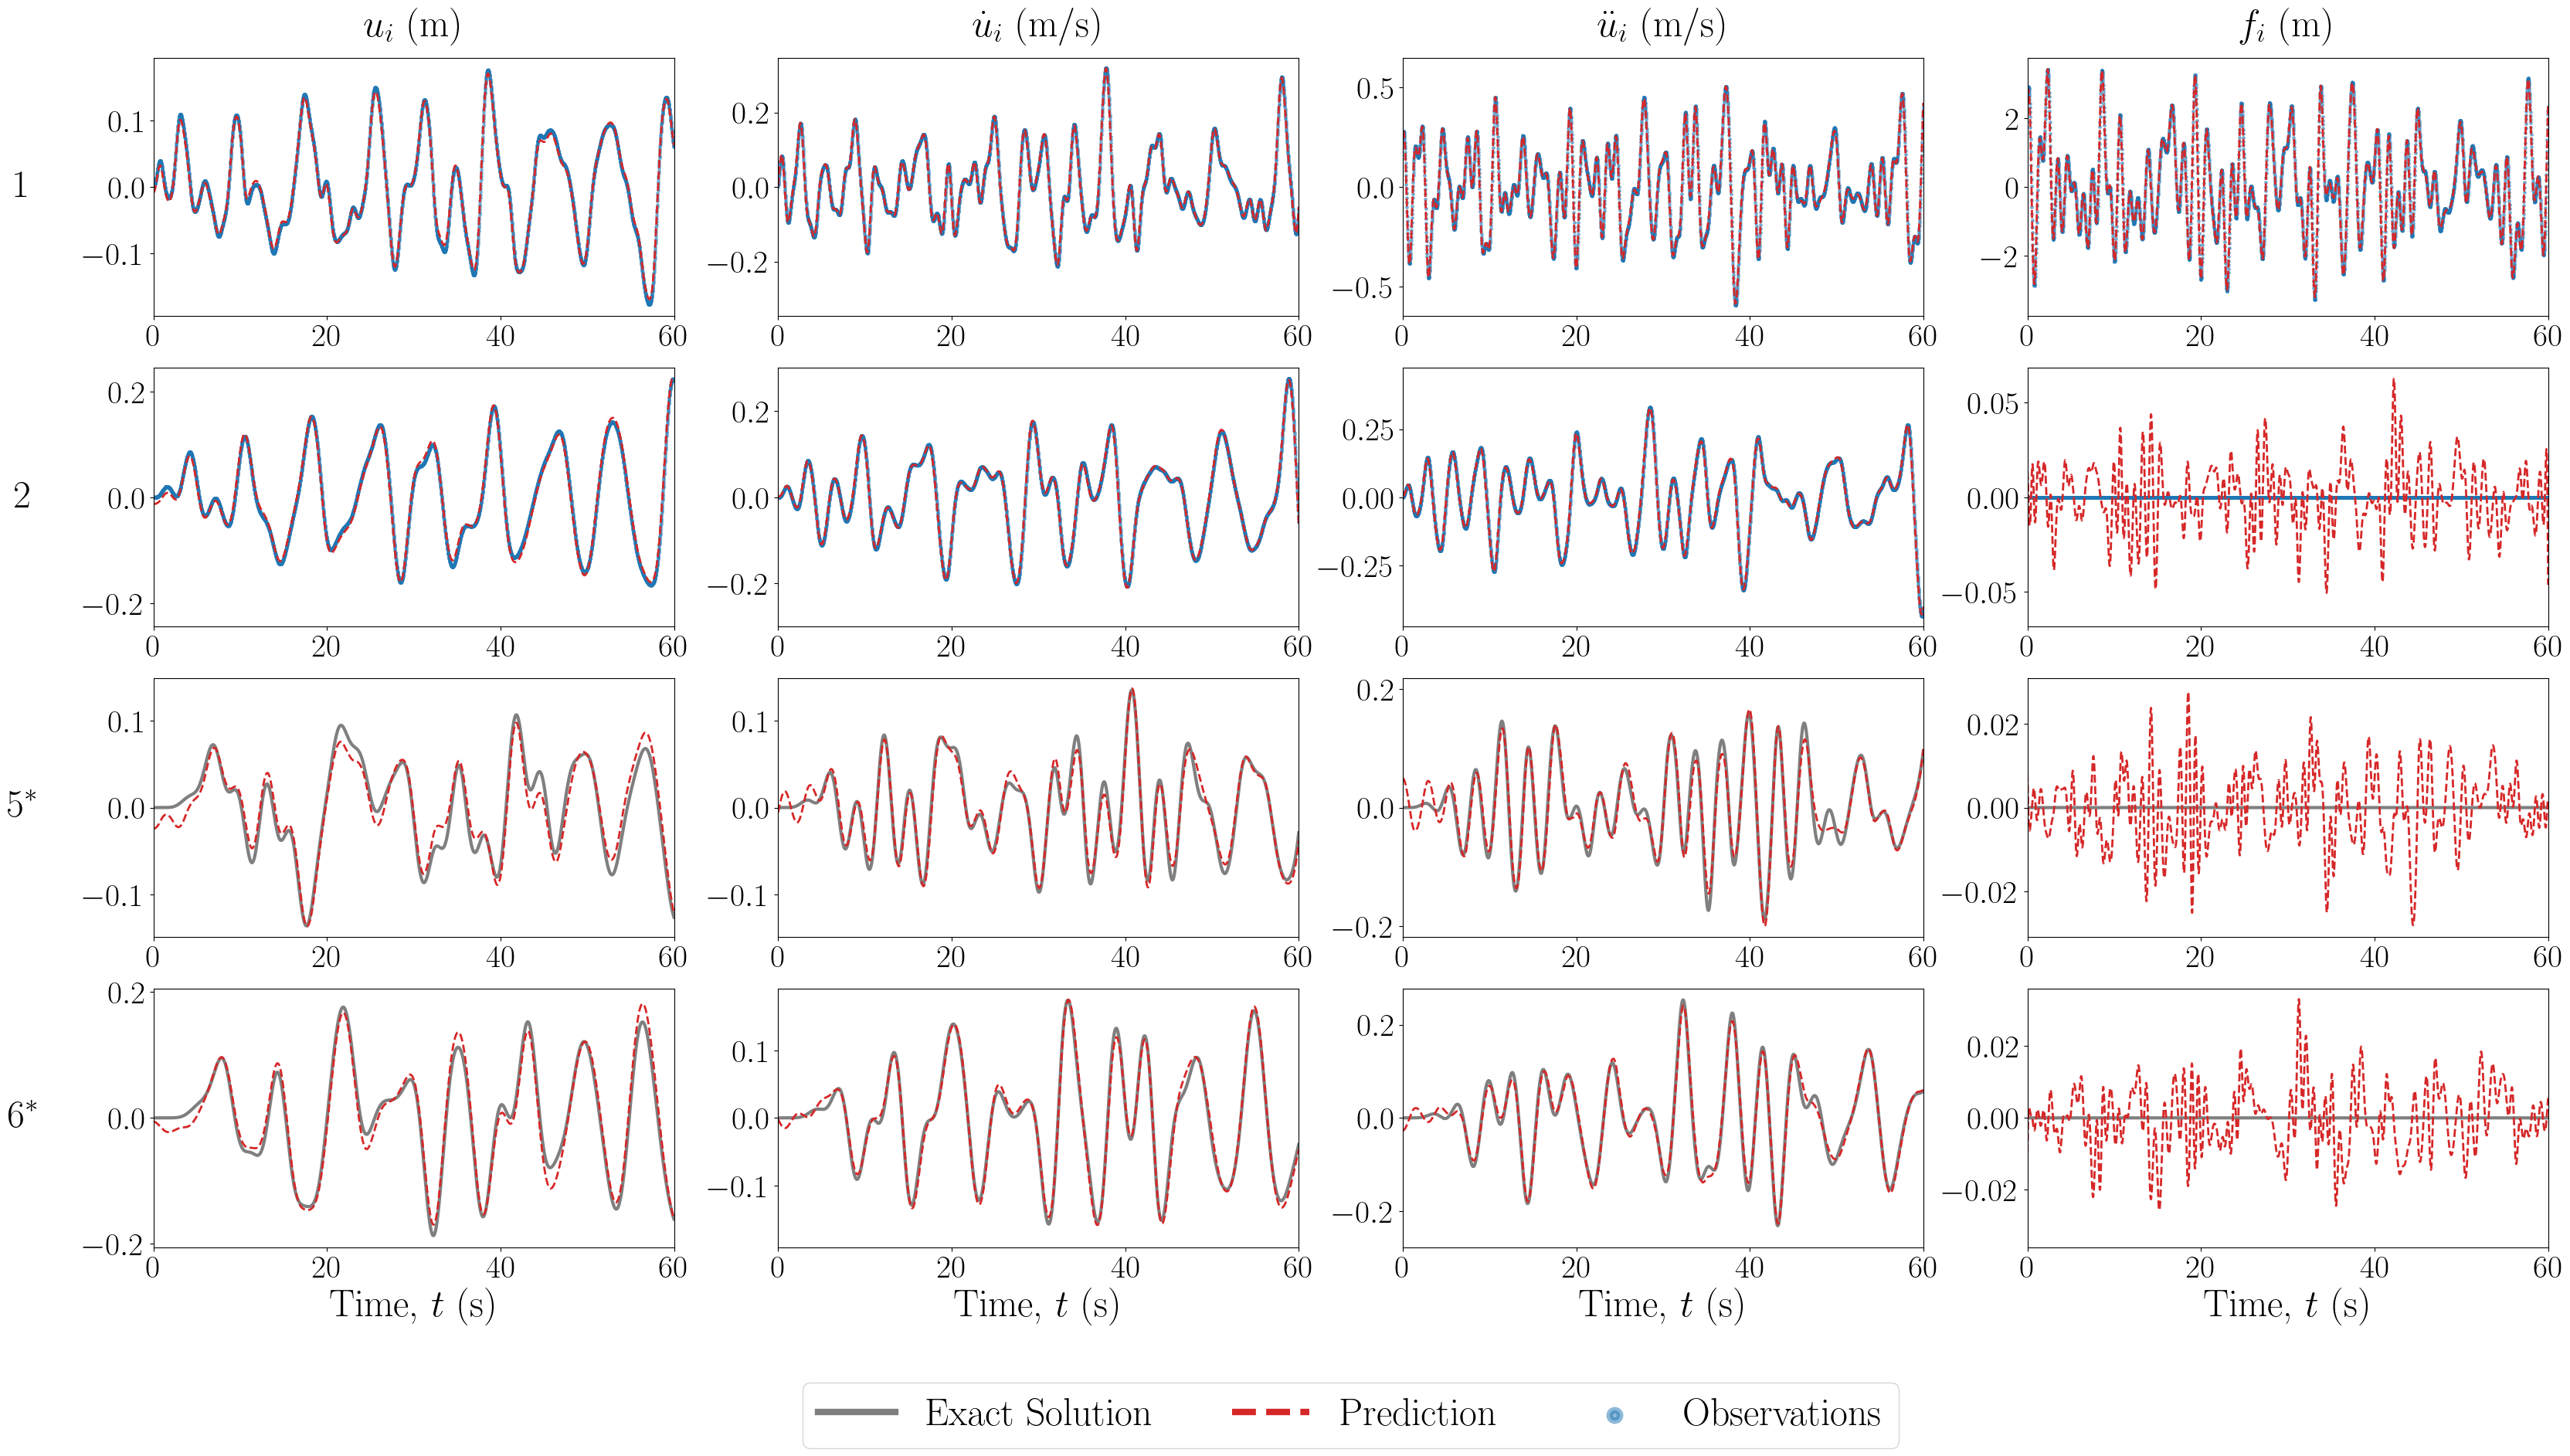

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})
dofs_to_plot = [0, 1, n_dof-2, n_dof-1]
snr = float(result_id[-5:-3])

text_width = 6.77
fig, axs = plt.subplots(len(dofs_to_plot), 4, figsize = (40, 20), facecolor='w')

dropouts = results['pinn_config']['dropouts']

xL = (np.min(ground_truth['t']), np.max(ground_truth['t']))

to_plot_names = ['x_hat', 'v_hat', 'a_hat', 'f_hat']
axs[0,0].set_title(r'$u_i$ (m)', fontsize=36, pad=20)
axs[0,1].set_title(r'$\dot{u}_i$ (m/s)', fontsize=36, pad=20)
axs[0,2].set_title(r'$\ddot{u}_i$ (m/s)', fontsize=36, pad=20)
axs[0,3].set_title(r'$f_i$ (m)', fontsize=36, pad=20)

# axs[0,0].text(0.05, 0.888, r'$i$', fontsize=36, transform=plt.gcf().transFigure)

alpha_keys = [name[:-4] for name in to_plot_names]
lin_keys = ['x', 'v', 'acc']
seeds = [43810, 13927, 2024, 1234]

for i, dof in enumerate(dofs_to_plot):
    
    # axs[dof, 0].set_ylabel(''.join(['$i=', str(dof), '$']), fontsize=36)
    # if dof == 1 or dof == 3:
    #     axs[dof,0].text(0.05, 0.81-0.16*dof, ''.join(('\\textbf{',str(dof+1),'}')), fontsize=30, color='red', transform=plt.gcf().transFigure)
    # else:
    #     axs[dof,0].text(0.05, 0.81-0.16*dof, str(dof+1), fontsize=30, transform=plt.gcf().transFigure)
    for kinetic, kinname in enumerate(to_plot_names):
        noisy_gt = add_noise(ground_truth[kinname], SNR=snr, seed = seeds[kinetic])
        axs[i, kinetic].set_facecolor('white')
        if any(np.array(dropouts)==dof):
            axs[i, kinetic].plot(ground_truth['t'], ground_truth[kinname][:, dof], color='black', linewidth=3.0, alpha=0.5, label='Exact Solution')
        else:
            axs[i, kinetic].scatter(ground_truth['t'][::1], noisy_gt[::1, dof], color='tab:blue', s=6, alpha=0.5, label='Observations')
        if all((result_id[-12:-6] == 'linmod', kinetic<3)):
            axs[i, kinetic].plot(ground_truth['t'], lin_solution[lin_keys[kinetic]][dof, :], color='tab:green', linewidth=2.0, linestyle='-.', label='Linear Solution')
        axs[i, kinetic].plot(prediction['t_hat']*alphas['t'].item(), prediction[kinname][:,dof]*alphas[alpha_keys[kinetic]].item(), color='tab:red', linewidth=2.0, linestyle='--', label='Prediction')
        axs[i, kinetic].set_xlim(xL)
        yL = np.max(np.abs(np.array(axs[i, kinetic].get_ylim())))
        axs[i, kinetic].set_ylim(-yL, yL)
        # axs[dof, kinetic].set_ylabel(r'$\dot{u}$ (m/s)' if kinetic else r'$u$ (m)', fontsize = 36)
        if dof == (n_dof-1): axs[i, kinetic].set_xlabel(r'Time, $t$ (s)', fontsize=36)
        axs[i, kinetic].tick_params(axis='both', which='both', labelsize=30)
        # axs[dof, kinetic].set_xticks([])
        # axs[dof, kinetic].set_yticks([])
    
    # axs[dof, 0].text(-12, 0, r'$\mathbf{'+f'{dof+1:d}'+'}$', fontsize=36, color='tab:red' if any(np.array(dropouts)==dof) else 'tab:blue', verticalalignment='center', horizontalalignment='center')
    axs[i, 0].text(-15, 0, r'$'+f'{dof+1:d}'+'^*$' if any(np.array(dropouts)==dof) else r'$'+f'{dof+1:d}'+'$', fontsize=36, verticalalignment='center', horizontalalignment='center')

if any(dofs_to_plot[-1] == np.array(dropouts)):
    axs[-1, 1].scatter([], [], color='tab:blue', s=6, alpha=0.5, label='Observations')
leg = axs[-1, 1].legend(fontsize=36, loc='upper center', bbox_to_anchor=(1.1, -0.45), ncol=4, markerscale=4.0)
for legobj in leg.legend_handles:
    legobj.set_linewidth(6.0)
    # if legobj.get_label() == 'Observations':
    #     legobj._sizes = [12.0]

In [ ]:
fig.savefig(f'results/figs/{result_id[10:]}.png', bbox_inches='tight', dpi=300)
fig.savefig(f'results/figs/{result_id[10:]}.eps', bbox_inches='tight', dpi=72)

In [6]:
rmse_all = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_obs = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_unobs = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_first = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_last = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}

fitness_all = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
fitness_first = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
fitness_last = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}

for dof in range(n_dof):
    for kinetic, kinname in enumerate(to_plot_names):
        ### Calculate performance metrics
        rmse_dof_kin = np.sqrt(np.mean((ground_truth[kinname][:, dof] - prediction[kinname][:, dof]*alphas[alpha_keys[kinetic]].item())**2))
        range_gt = np.max(ground_truth[kinname][:, dof]) - np.min(ground_truth[kinname][:, dof])
        fitness_dof_kin = (1 - rmse_dof_kin / range_gt) * 100
        
        rmse_all[kinname[:-4]] += rmse_dof_kin
        fitness_all[kinname[:-4]] += fitness_dof_kin / n_dof
    
        if dof == 0:
            rmse_first[kinname[:-4]] = rmse_dof_kin
            fitness_first[kinname[:-4]] = fitness_dof_kin
        if dof == n_dof-1:
            rmse_last[kinname[:-4]] = rmse_dof_kin
            fitness_last[kinname[:-4]] = fitness_dof_kin
        
        if any(np.array(dropouts)==dof):
            # Add to NMSE for dropouts
            rmse_unobs[kinname[:-4]] += rmse_dof_kin
        else:
            # Add to NMSE for observed
            rmse_obs[kinname[:-4]] += rmse_dof_kin
        

write_str = f'ID: {result_id}\n\n'
write_str += f'Loss: {results["loss"][-1][-1]:.3e}\n\n'

latex_write_str_1 = ''
latex_write_str_2 = ''
latex_write_str_3 = ''
    
for key, value in fitness_all.items():
    write_str += f'Fitness - All ({key}): {value:.3f}\n'
    write_str += f'Fitness - First ({key}): {fitness_first[key]:.3f}\n'
    write_str += f'Fitness - Last ({key}): {fitness_last[key]:.3f}\n\n'
    
    latex_write_str_1 += f'{fitness_all[key]:.2f} & '
    latex_write_str_2 += f'{fitness_first[key]:.2f} & '
    latex_write_str_3 += f'{fitness_last[key]:.2f} & '

print(write_str)
print(latex_write_str_1 + latex_write_str_2 + latex_write_str_3)

ID: 20240820__sr_exten_67dr_6dof_valerr_50snr

Loss: 7.103e-04

Fitness - All (x): 96.300
Fitness - First (x): 98.770
Fitness - Last (x): 95.967

Fitness - All (v): 98.062
Fitness - First (v): 99.639
Fitness - Last (v): 97.722

Fitness - All (a): 97.935
Fitness - First (a): 99.558
Fitness - Last (a): 97.721

Fitness - All (f): -inf
Fitness - First (f): 99.461
Fitness - Last (f): -inf


96.30 & 98.06 & 97.94 & -inf & 98.77 & 99.64 & 99.56 & 99.46 & 95.97 & 97.72 & 97.72 & -inf & 


/var/folders/w8/_lnhm_b11w759xx3q8t1l9800000gn/T/ipykernel_7337/2363262154.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  fitness_dof_kin = (1 - rmse_dof_kin / range_gt) * 100


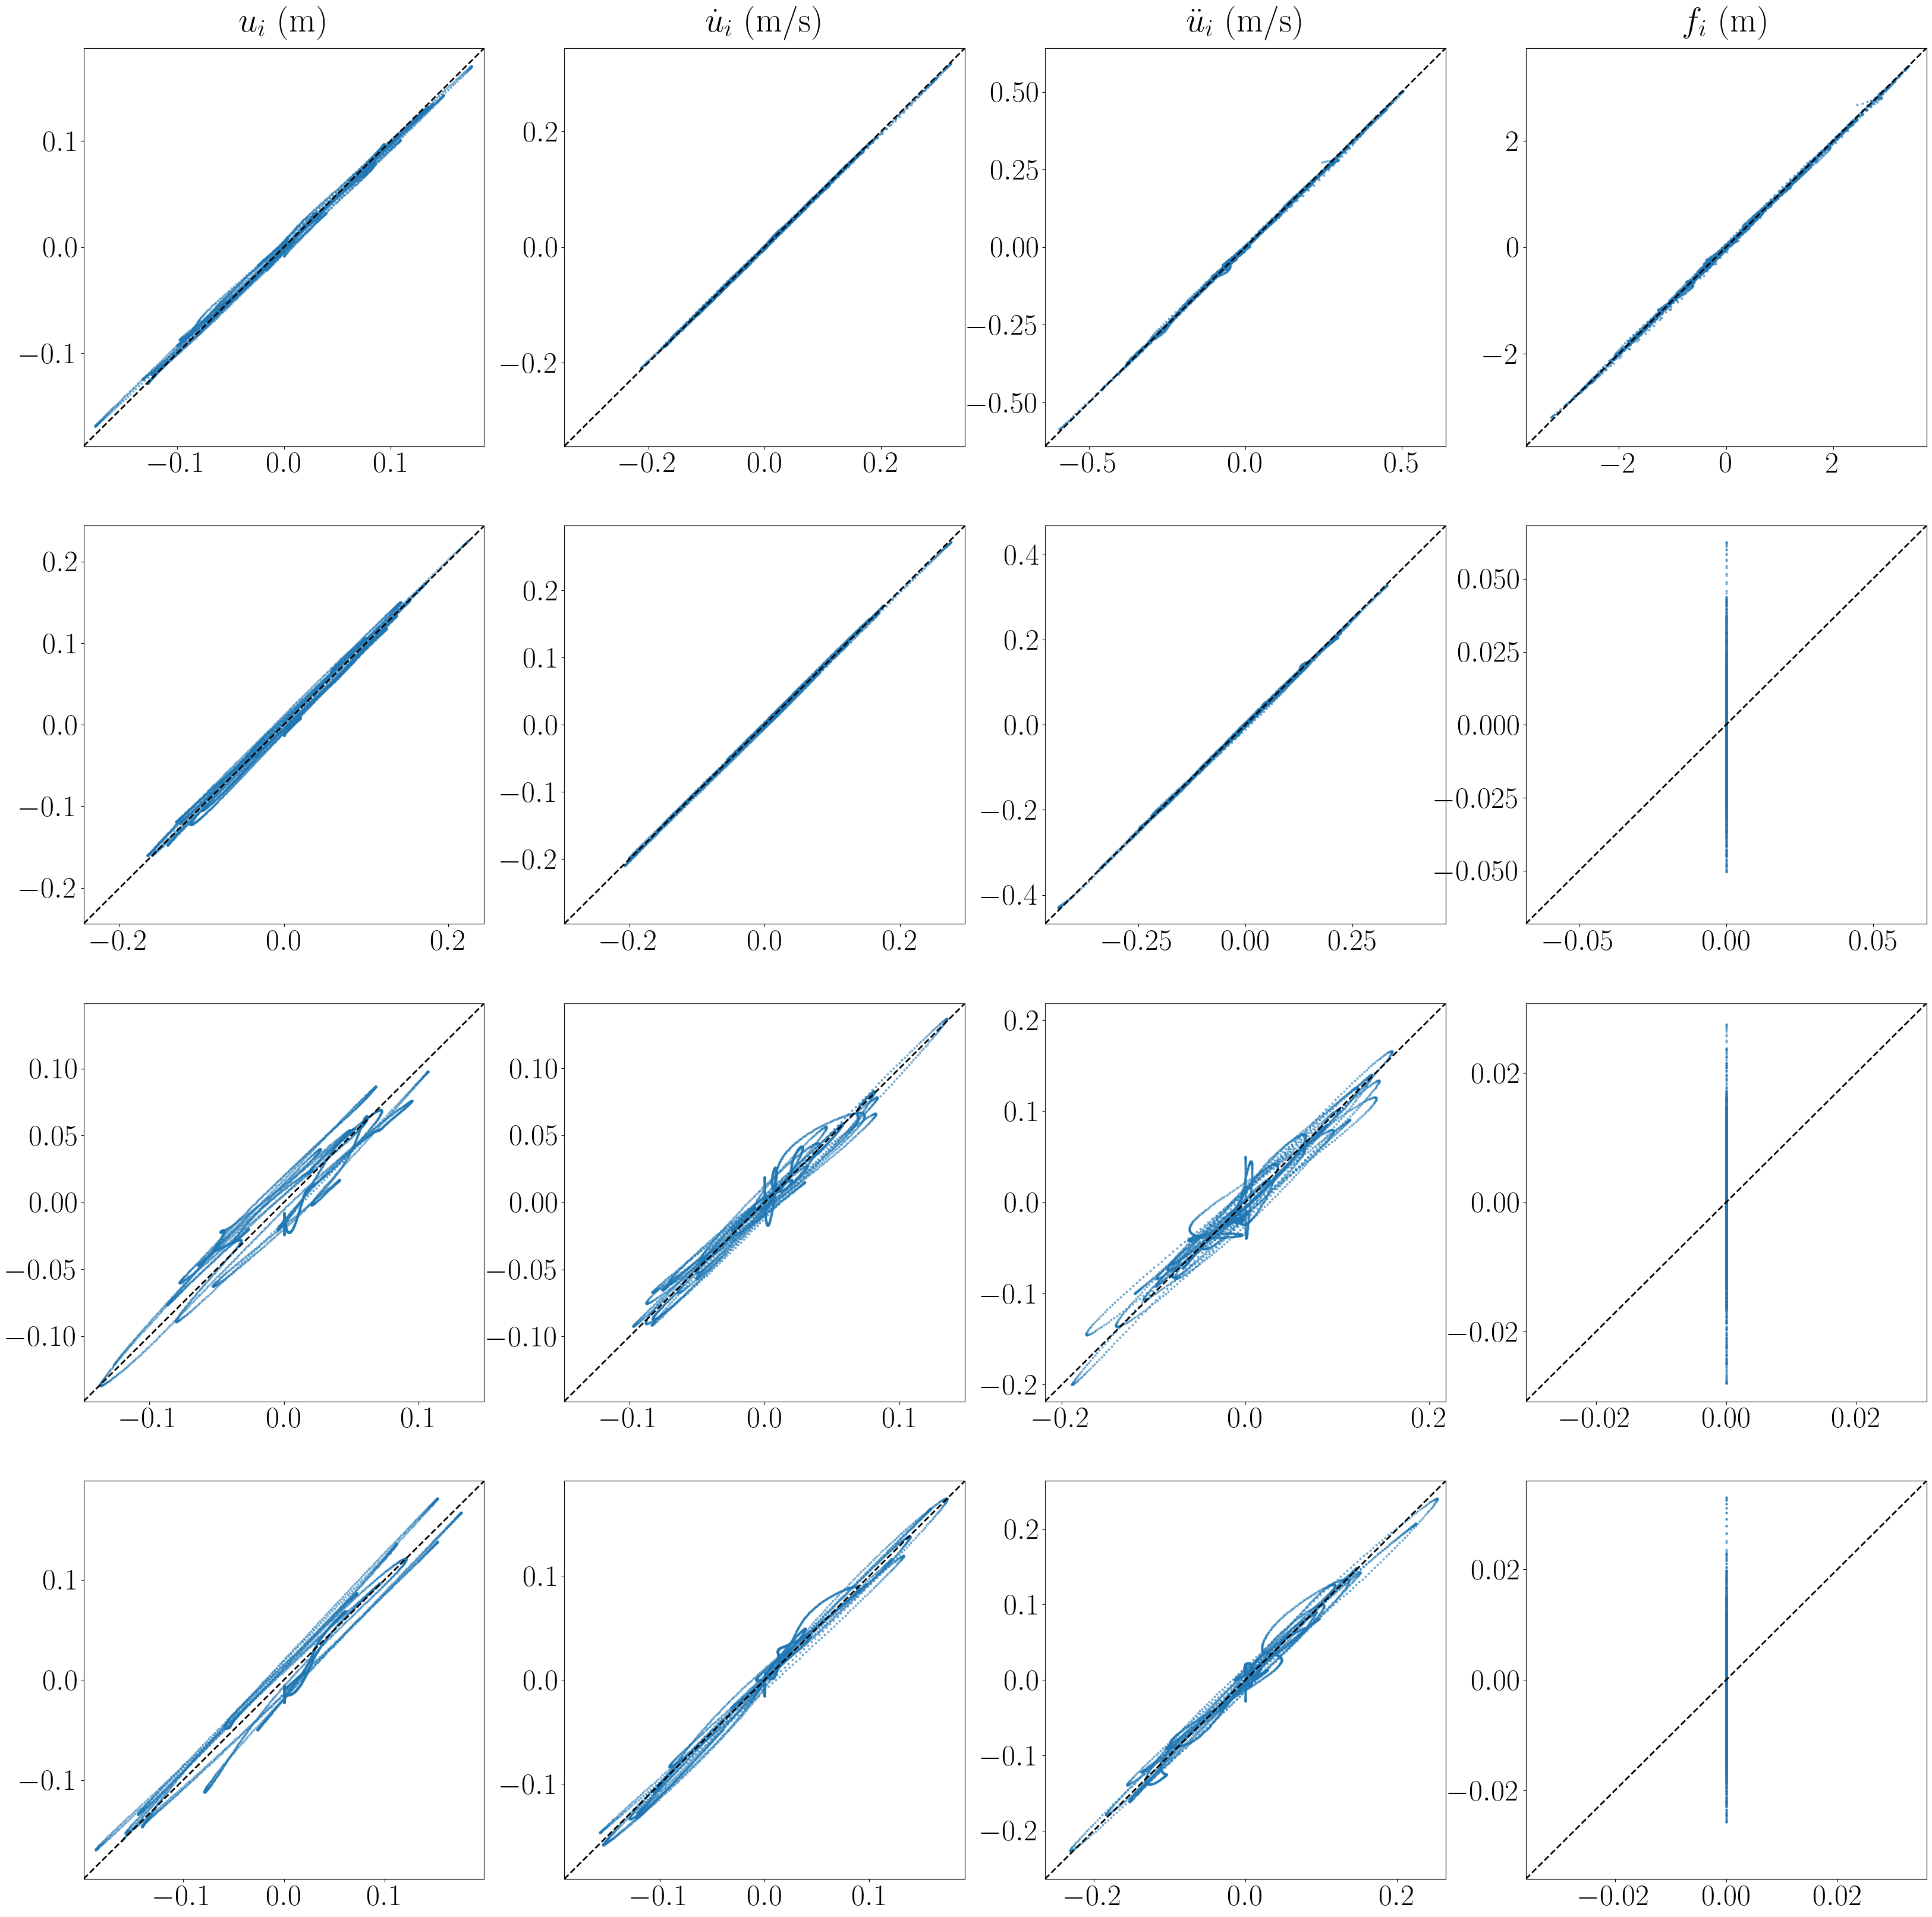

In [7]:
dofs_to_plot = [0, 1, n_dof-2, n_dof-1]
fig, axs = plt.subplots(len(dofs_to_plot), 4, figsize = (40, 40), facecolor='w')

dropouts = results['pinn_config']['dropouts']

xL = (np.min(ground_truth['t']), np.max(ground_truth['t']))

to_plot_names = ['x_hat', 'v_hat', 'a_hat', 'f_hat']
big_font_size = 42

axs[0,0].set_title(r'$u_i$ (m)', fontsize=big_font_size, pad=20)
axs[0,1].set_title(r'$\dot{u}_i$ (m/s)', fontsize=big_font_size, pad=20)
axs[0,2].set_title(r'$\ddot{u}_i$ (m/s)', fontsize=big_font_size, pad=20)
axs[0,3].set_title(r'$f_i$ (m)', fontsize=big_font_size, pad=20)

# axs[0,0].text(0.05, 0.888, r'$i$', fontsize=36, transform=plt.gcf().transFigure)

alpha_keys = [name[:-4] for name in to_plot_names]
lin_keys = ['x', 'v', 'acc']

for i, dof in enumerate(dofs_to_plot):
    for kinetic, kinname in enumerate(to_plot_names):
        axs[i, kinetic].set_facecolor('white')
        axs[i, kinetic].scatter(ground_truth[kinname][:, dof], prediction[kinname][:,dof]*alphas[alpha_keys[kinetic]].item(), s=4, alpha=0.5)
        yL = np.max(np.abs(np.array(axs[i, kinetic].get_ylim())))
        if all((result_id[-21:-15] == 'linmod', kinetic<3)):
            axs[dof, kinetic].scatter(ground_truth[kinname][:, dof], lin_solution[lin_keys[kinetic]][dof, :], s=4, color='tab:green', alpha=0.5, label='Linear Solution')
        axs[i, kinetic].plot([-yL, yL], [-yL, yL], color='black', linewidth=2.0, linestyle='--')
        axs[i, kinetic].set_ylim(-yL, yL)
        axs[i, kinetic].set_xlim(-yL, yL)
        
        # if dof == (n_dof-1): axs[dof, kinetic].set_xlabel(r'Time, $t$ (s)', fontsize=big_font_size)
        axs[i, kinetic].tick_params(axis='both', which='both', labelsize=36)

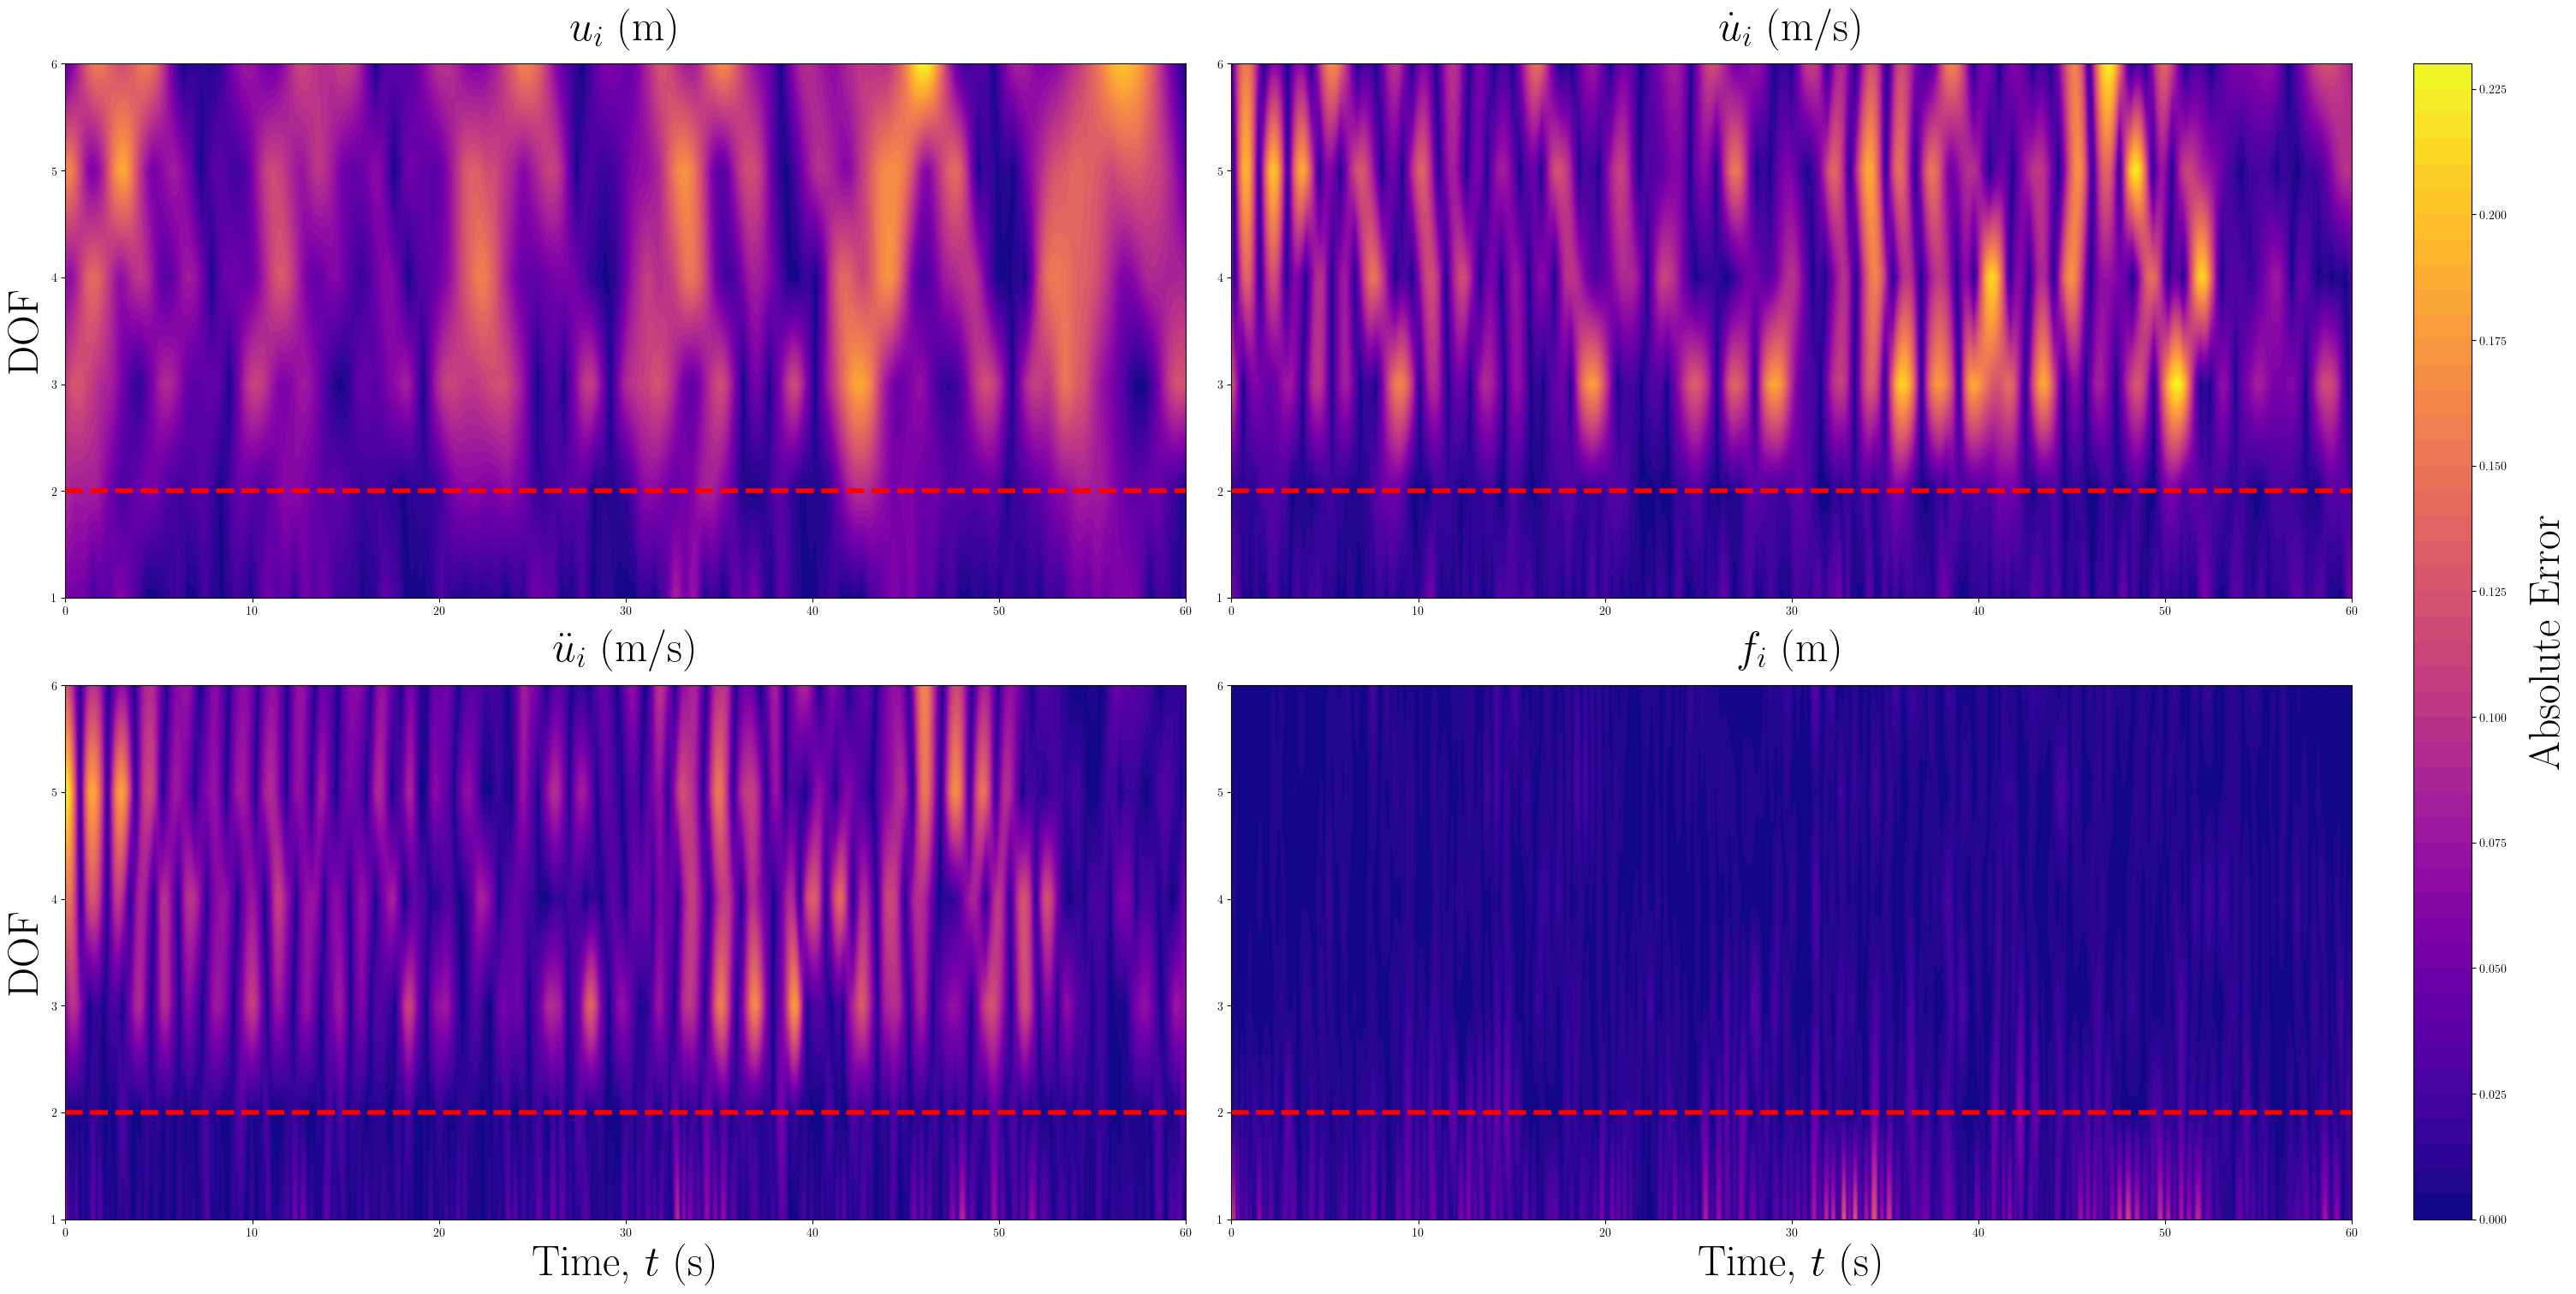

In [18]:
fig, axs = plt.subplots(2, 2, figsize = (30, 15), facecolor='w', layout='constrained')
axs = axs.ravel()

dropouts = results['pinn_config']['dropouts']

xL = (np.min(ground_truth['t']), np.max(ground_truth['t']))

to_plot_names = ['x_hat', 'v_hat', 'a_hat', 'f_hat']
axs[0].set_title(r'$u_i$ (m)', fontsize=36, pad=20)
axs[1].set_title(r'$\dot{u}_i$ (m/s)', fontsize=36, pad=20)
axs[2].set_title(r'$\ddot{u}_i$ (m/s)', fontsize=36, pad=20)
axs[3].set_title(r'$f_i$ (m)', fontsize=36, pad=20)

alpha_keys = [name[:-4] for name in to_plot_names]

tt_mat, dof_mat = np.meshgrid(ground_truth['t'], np.arange(1, n_dof+1))

def error_func(x, y):
    # row_range = np.max(np.abs(y), axis=1)
    # abs_diff = np.abs(x - y)
    # init_err = np.abs(x - y) / np.abs(y) * 100
    # zero_locs = (init_err > 2e2) * np.isnan(init_err)
    # return np.abs(x - y) / np.abs(y) * 100 * ~zero_locs
    # return (np.abs(x-y).T / row_range).T * 100
    return np.abs(x-y)

for kinetic, kinname in enumerate(to_plot_names):
    axs[kinetic].set_facecolor('white')
    error_mat = error_func(prediction[kinname].T*alphas[alpha_keys[kinetic]].item(), ground_truth[kinname].T)
    im1 = axs[kinetic].contourf(tt_mat, dof_mat, error_mat, cmap='plasma', levels=50)
    axs[kinetic].set_xlim(xL)
    axs[kinetic].set_ylim(1, n_dof)
    axs[kinetic].axhline(y=min(dropouts), color='red', linewidth=4.0, linestyle='--')
    if kinetic == 3: 
        cbar = fig.colorbar(im1, ax=axs[[1,3]], pad=0.05)
        cbar.set_label(r'Absolute Error', fontsize=36, labelpad=20)
        # cbar.ax.tick_params(labelsize=30)
        # cbar.ax.yaxis.get_offset_text().set_fontsize(30)
    if kinetic > 1: axs[kinetic].set_xlabel(r'Time, $t$ (s)', fontsize=36)
    # axs[kinetic].tick_params(axis='both', which='both', labelsize=30)
    # axs[kinetic].set_yticks(np.array([1, 5, 10, 15, 20]))
    if kinetic%2 == 0: axs[kinetic].set_ylabel(r'DOF', fontsize=36)


In [16]:
fig.savefig(f'results/figs/{result_id[10:]}_error_mat.png', bbox_inches='tight', dpi=300)
fig.savefig(f'results/figs/{result_id[10:]}_error_mat.eps', bbox_inches='tight', dpi=72)